In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import discretize
from discretize import TensorMesh
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG.utils import plot_1d_layer_model
from SimPEG import maps
from deap import base, creator, tools, algorithms
from utilities.gex_parser import parse_gex_file

In [2]:
gex_file = parse_gex_file('../data/20181211_312_Butte_DualWaveform_60Hz_skb_SR2.gex')
gex_file

{'General': {'Description': 'Test geometry file',
  'GPSDifferentialPosition2': array([10.51,  3.95, -0.16]),
  'GPSPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition2': array([10.51,  3.95, -0.16]),
  'AltimeterPosition1': array([12.94,  1.79, -0.12]),
  'AltimeterPosition2': array([12.94, -1.79, -0.12]),
  'InclinometerPosition1': array([12.79,  1.64, -0.12]),
  'InclinometerPosition2': array([12.79,  1.64, -0.12]),
  'RxCoilPosition1': array([-13.25,   0.  ,  -2.  ]),
  'LoopType': 73,
  'FrontGateDelay': 2.5e-06,
  'TxLoopArea': 342,
  'NumberOfTurnsLM': 2,
  'NumberOfTurnsHM': 12,
  'RxCoilLPFilter1': array([9.9e-01, 2.1e+05]),
  'TxLoopPoints': array([[-12.55,  -2.1 ],
         [ -6.03,  -8.63],
         [  6.03,  -8.63],
         [ 11.34,  -3.31],
         [ 11.34,   3.31],
         [  6.03,   8.63],
         [ -6.03,   8.63],
         [-12.55,   2.1 ]]),
  'Waveforms': {'HM': {'time': array([-2.0667e-02, -2.0460e-02, -2.0352e-02, -1.6667e-02, -1.6638e-02,
           -1.65

In [3]:
data_file = pd.read_csv('../data/Butte_EM312_MAG.xyz')
data_file

,Fid,Line,Flight,DateTime,Date,Time,AngleX,AngleY,Height,Lon,...,HM_X_G01[35],HM_X_G01[36],PLNI,Bmag,Mag_Raw,Mag_Ed,Diurnal,Mag_Cor,RMF,TMI
0,57343.7,100101,20181130.01,43434.663700,2018/11/30,15:55:44,14.501628,-2.484009,50.620338,-122.141912,...,0.002313,0.001824,19.661216,49756.680861,49824.9253,49824.9253,9.180861,49815.809285,522.039006,49815.924332
1,57343.8,100101,20181130.01,43434.663701,2018/11/30,15:55:44,14.626247,-2.606263,50.667276,-122.141911,...,0.002353,0.001853,19.492215,49756.684677,49825.6155,49825.6155,9.184677,49816.427630,522.659842,49816.540790
2,57343.9,100101,20181130.01,43434.663703,2018/11/30,15:55:44,14.756285,-2.733695,50.709210,-122.141911,...,0.002392,0.001882,19.323215,49756.688493,49826.2035,49826.2035,9.188493,49817.047647,523.282283,49817.158832
3,57344.0,100101,20181130.01,43434.663704,2018/11/30,15:55:44,14.890768,-2.866267,50.745223,-122.141910,...,0.002429,0.001911,19.155125,49756.692309,49826.8315,49826.8315,9.192309,49817.664802,523.901775,49817.773921
4,57344.1,100101,20181130.01,43434.663705,2018/11/30,15:55:44,15.028540,-3.003910,50.774454,-122.141909,...,0.002465,0.001939,18.986215,49756.696124,49827.4946,49827.4946,9.196124,49818.274453,524.513660,49818.381410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227478,166590.6,710601,20181201.02,43435.928132,2018/12/01,22:16:31,-5.338477,0.387803,41.014626,-121.761352,...,-0.003716,0.001413,55.064422,49745.359376,49263.2320,49263.2320,-2.140624,49265.246194,-76.905084,49265.279858
227479,166590.7,710601,20181201.02,43435.928133,2018/12/01,22:16:31,-5.154121,0.339078,40.743338,-121.761319,...,-0.003736,0.001421,54.136189,49745.358910,49263.0601,49263.0601,-2.141090,49265.106910,-77.053997,49265.136171
227480,166590.8,710601,20181201.02,43435.928134,2018/12/01,22:16:31,-4.969279,0.291122,40.470529,-121.761287,...,-0.003754,0.001429,53.208189,49745.358444,NaN,NaN,-2.141556,49264.967420,-77.202995,49264.992367
227481,166590.9,710601,20181201.02,43435.928135,2018/12/01,22:16:31,-4.786065,0.244063,40.196134,-121.761254,...,-0.003773,0.001437,52.279339,49745.357977,NaN,NaN,-2.142023,49264.828063,-77.351729,49264.848787


In [4]:
data_file[data_file==9999] = np.nan

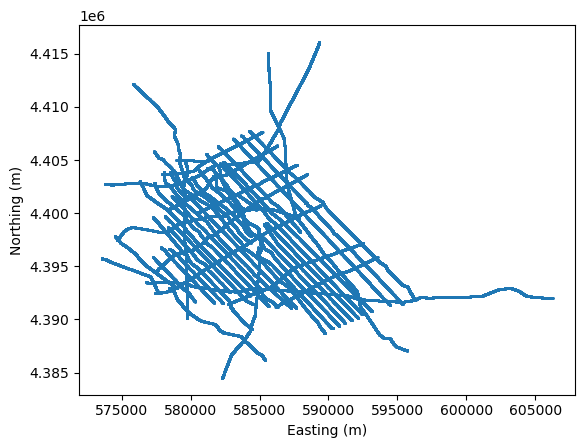

In [5]:
plt.scatter(data_file.E, data_file.N, s=0.5)
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');

In [6]:
n_lm_gates = gex_file['Channel1']['NoGates'] - gex_file['Channel1']['RemoveInitialGates']
n_hm_gates = gex_file['Channel2']['NoGates'] - gex_file['Channel2']['RemoveInitialGates']

In [7]:
line_no = 101501
line_grouping = data_file.groupby('Line')
line = line_grouping.get_group(line_no)

In [8]:
# Seleccionar todas las columnas que empiezan con 'LM_Z_'
lm_data = line.filter(regex='^LM_Z_')

# Seleccionar todas las columnas que empiezan con 'HM_Z_'
hm_data = line.filter(regex='^HM_Z_')

print("Columnas seleccionadas para Low Moment (LM):")
print(lm_data.columns)
print("\nColumnas seleccionadas para High Moment (HM):")
print(hm_data.columns)
#lm_data = line.iloc[:, 9:9+n_lm_gates]
#hm_data = line.iloc[:, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates]

Columnas seleccionadas para Low Moment (LM):
Index(['LM_Z_G01[0]', 'LM_Z_G01[1]', 'LM_Z_G01[2]', 'LM_Z_G01[3]',
       'LM_Z_G01[4]', 'LM_Z_G01[5]', 'LM_Z_G01[6]', 'LM_Z_G01[7]',
       'LM_Z_G01[8]', 'LM_Z_G01[9]', 'LM_Z_G01[10]', 'LM_Z_G01[11]',
       'LM_Z_G01[12]', 'LM_Z_G01[13]', 'LM_Z_G01[14]', 'LM_Z_G01[15]',
       'LM_Z_G01[16]', 'LM_Z_G01[17]', 'LM_Z_G01[18]', 'LM_Z_G01[19]',
       'LM_Z_G01[20]', 'LM_Z_G01[21]', 'LM_Z_G01[22]', 'LM_Z_G01[23]',
       'LM_Z_G01[24]', 'LM_Z_G01[25]', 'LM_Z_G01[26]', 'LM_Z_G01[27]'],
      dtype='object')

Columnas seleccionadas para High Moment (HM):
Index(['HM_Z_G01[0]', 'HM_Z_G01[1]', 'HM_Z_G01[2]', 'HM_Z_G01[3]',
       'HM_Z_G01[4]', 'HM_Z_G01[5]', 'HM_Z_G01[6]', 'HM_Z_G01[7]',
       'HM_Z_G01[8]', 'HM_Z_G01[9]', 'HM_Z_G01[10]', 'HM_Z_G01[11]',
       'HM_Z_G01[12]', 'HM_Z_G01[13]', 'HM_Z_G01[14]', 'HM_Z_G01[15]',
       'HM_Z_G01[16]', 'HM_Z_G01[17]', 'HM_Z_G01[18]', 'HM_Z_G01[19]',
       'HM_Z_G01[20]', 'HM_Z_G01[21]', 'HM_Z_G01[22]'

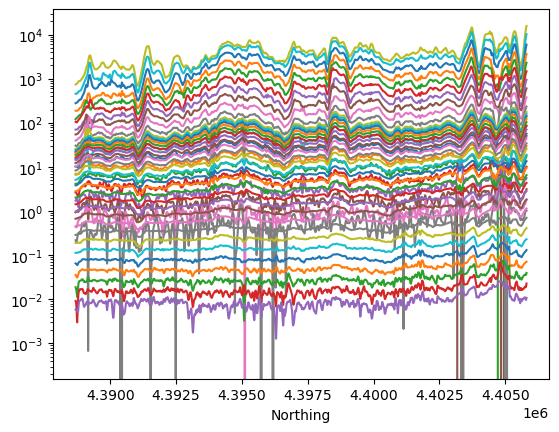

In [9]:
plt.semilogy(line.N, lm_data)
plt.semilogy(line.N, hm_data)
plt.xlabel('Northing');

In [10]:
channel_info_lm = gex_file['Channel1']
first_gate_lm = channel_info_lm['RemoveInitialGates']
n_lm_gates = channel_info_lm['NoGates']

channel_info_hm = gex_file['Channel2']
first_gate_hm = channel_info_hm['RemoveInitialGates']
n_hm_gates = channel_info_hm['NoGates']

station = line[line.Fid==156405.3]

all_station_lm_data = station.filter(regex='^LM_Z_')
all_station_hm_data = station.filter(regex='^HM_Z_')

station_lm_data_selection = all_station_lm_data.iloc[:, first_gate_lm : first_gate_lm + n_lm_gates]
station_hm_data_selection = all_station_hm_data.iloc[:, first_gate_hm : first_gate_hm + n_hm_gates]

station_lm_data = station_lm_data_selection.to_numpy().flatten()
station_hm_data = station_hm_data_selection.to_numpy().flatten()


print(f"\nDatos extraídos para la estación:")
print(f"  - Puntos de datos LM extraídos: {len(station_lm_data)}")
print(f"  - Puntos de datos HM extraídos: {len(station_hm_data)}")


# select a single sounding along that line, and grab all of the data associated with that station
# Record 5590
#station = line[line.Fid==57344.0]
#station_lm_data = station.filter(regex='^LM_Z_').to_numpy().flatten()
#station_hm_data = station.filter(regex='^HM_Z_').to_numpy().flatten()


#print(f"\nDatos extraídos para la estación:")
#print(f"  - LM_Z: {station_lm_data.shape[0]} puntos")
#print(f"  - HM_Z: {station_hm_data.shape[0]} puntos")
#station_lm_data = station.iloc[0, 9:9+n_lm_gates].to_numpy()
#station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
#station_hm_data = station.iloc[0, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates].to_numpy()
#station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()


Datos extraídos para la estación:
  - Puntos de datos LM extraídos: 28
  - Puntos de datos HM extraídos: 27


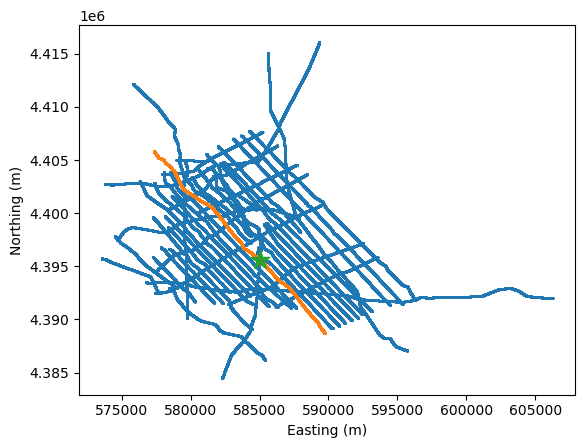

In [11]:
plt.scatter(data_file.E, data_file.N, s=0.5)
plt.scatter(line.E, line.N, s=0.5)
plt.scatter(station.E, station.N, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)');

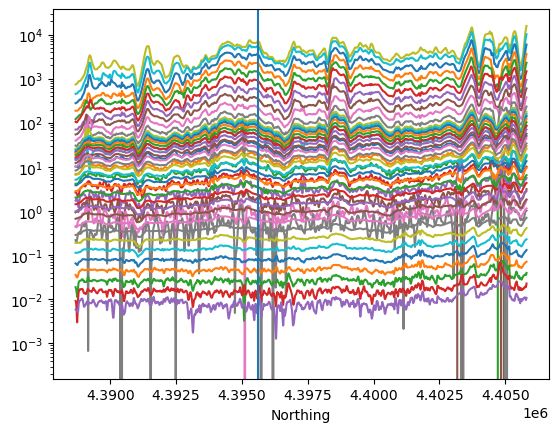

In [12]:
plt.semilogy(line.N, lm_data)
plt.semilogy(line.N, hm_data)
plt.axvline(station.N.iloc[0]);
plt.xlabel('Northing');

In [13]:
station

,Fid,Line,Flight,DateTime,Date,Time,AngleX,AngleY,Height,Lon,...,HM_X_G01[35],HM_X_G01[36],PLNI,Bmag,Mag_Raw,Mag_Ed,Diurnal,Mag_Cor,RMF,TMI
60002,156405.3,101501,20181201.01,43435.810247,2018/12/01,19:26:45,-0.67928,-0.413653,36.037309,-122.007967,...,-0.001332,0.000199,11.228414,49743.811482,49625.7608,49625.7608,-3.688518,49629.461312,312.282909,49629.114476


In [14]:
gate_centers = gex_file['General']['GateTimes']['center']

channel_info = gex_file['Channel1']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
lm_times = gate_centers[first_gate:last_gate] + shift + delay

channel_info = gex_file['Channel2']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
hm_times = gate_centers[first_gate:last_gate] + shift + delay

print(f"Número de compuertas de tiempo LM calculadas: {len(lm_times)}")
print(f"Número de compuertas de tiempo HM calculadas: {len(hm_times)}")

Número de compuertas de tiempo LM calculadas: 28
Número de compuertas de tiempo HM calculadas: 27


In [15]:
lm_good_data = ~np.isnan(station_lm_data)
hm_good_data = ~np.isnan(station_hm_data)

lm_times = lm_times[lm_good_data]
hm_times = hm_times[hm_good_data]
 
station_lm_data = station_lm_data[lm_good_data]*1E-12 
#station_lm_std = station_lm_std[lm_good_data]
station_hm_data = station_hm_data[hm_good_data]*1E-12
#station_hm_std = station_hm_std[hm_good_data]

# and of course reset our counts too
n_lm_gates = len(lm_times)
n_hm_gates = len(hm_times)

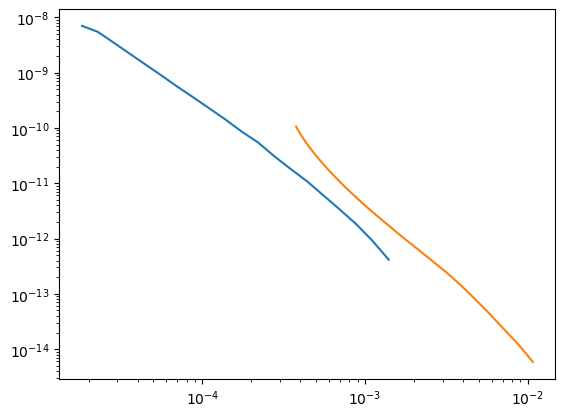

In [16]:
plt.loglog(lm_times, station_lm_data)
plt.loglog(hm_times, station_hm_data)

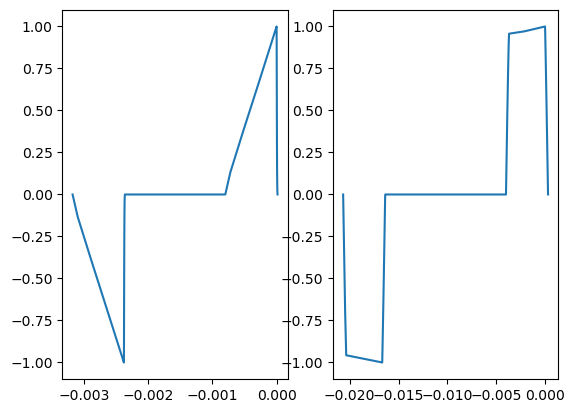

In [17]:
waves = gex_file['General']['Waveforms']
lm_wave_time = waves['LM']['time']
lm_wave_form = waves['LM']['form']
hm_wave_time = waves['HM']['time']
hm_wave_form = waves['HM']['form']
plt.subplot(121)
plt.plot(lm_wave_time, lm_wave_form)
plt.subplot(122)
plt.plot(hm_wave_time, hm_wave_form);

array([[-12.55,  -2.1 ,   0.  ],
       [ -6.03,  -8.63,   0.  ],
       [  6.03,  -8.63,   0.  ],
       [ 11.34,  -3.31,   0.  ],
       [ 11.34,   3.31,   0.  ],
       [  6.03,   8.63,   0.  ],
       [ -6.03,   8.63,   0.  ],
       [-12.55,   2.1 ,   0.  ],
       [-12.55,  -2.1 ,   0.  ]])

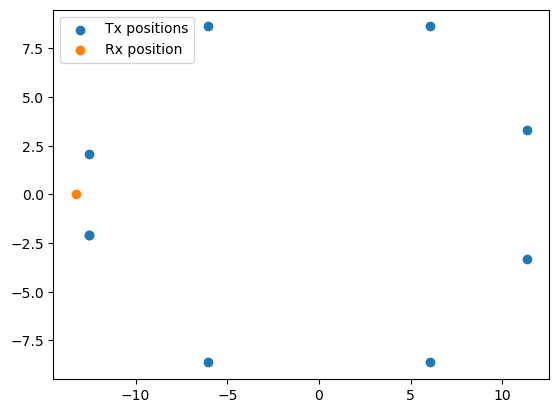

In [18]:
# We pad the locations of the Tx points with 0, to expand it from a 2D (x,y) pair to a 3D (x, y, z) pair.
# We also add another row because we will need to close the transmitter loop.
tx_shape = np.pad(gex_file['General']['TxLoopPoints'], (0, 1))
tx_shape[-1] = tx_shape[0]

rx_offset = gex_file['General']['RxCoilPosition1']

plt.scatter(*tx_shape[:, :-1].T, label='Tx positions')
plt.scatter(*rx_offset[:-1], label='Rx position')
plt.legend()

tx_shape

In [19]:
tx_loc = tx_shape + [station.E.iloc[0], station.N.iloc[0], station.Height.iloc[0]]
rx_loc = rx_offset + [station.E.iloc[0], station.N.iloc[0], station.Height.iloc[0]]
# also let's grab the area
tx_area = gex_file['General']['TxLoopArea']
#tx_current_lm = station['Curr_LM'].iloc[0]
#tx_current_hm = station['Curr_HM'].iloc[0]
#tx_current_lm = gex_file['Channel1']['TxApproximateCurrent']
#tx_current_hm = gex_file['Channel2']['TxApproximateCurrent']

In [20]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, lm_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(lm_wave_time, lm_wave_form)
#lm_wave.currents = lm_wave.currents * gex_file['General']['NumberOfTurnsLM'] # considerar numero de vueltas
#lm_wave.currents = lm_wave.currents * gex_file['Channel1']['PrimaryFieldDampingFactor'] # considerar damping factor

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [21]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)
#hm_wave.currents = hm_wave.currents * gex_file['General']['NumberOfTurnsHM'] # considerar numero de vueltas
#hm_wave.currents = hm_wave.currents * gex_file['Channel2']['PrimaryFieldDampingFactor'] # considerar damping factor

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

In [22]:
srv = tdem.Survey([src_lm, src_hm])

In [23]:
#first a simple test
#thicknesses = [station['Height'][3],30,200]
thicknesses = [30,200]
#thicknesses = [10,30]
conductivities = [1E1, 1, 1E-3]
#conductivities = [1/30, 1/15, 1/7]

In [24]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

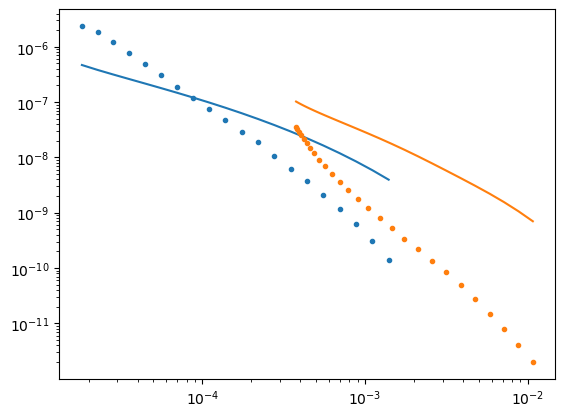

In [25]:
#sim.thicknesses = [5]
#sim.sigma = [1E-1, 2E1]
pre = -sim.dpred(None)
pre_lm = pre[:n_lm_gates]
pre_hm = pre[n_lm_gates:]

plt.loglog(lm_times, pre_lm)
plt.loglog(hm_times, pre_hm)
plt.loglog(lm_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='')
plt.loglog(hm_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='')

In [26]:
from SimPEG.data import Data
import numpy as np

dobs = - tx_area * np.r_[station_lm_data, station_hm_data]
relative_error = 3*0.01*abs(dobs)
noise_floor = 1e-12 
data_container = Data(
    survey=srv,
    dobs=dobs,
    relative_error=relative_error,
    noise_floor=noise_floor
)

uncertainties = 0.05 * np.abs(dobs) + 1e-15 

n_lm_gates_final = len(lm_times)

In [27]:
print(f"   - Total de puntos de datos para invertir: {len(dobs)}")
print(f"   - Puntos de Bajo Momento (LM): {n_lm_gates_final}")
print(f"   - Puntos de Alto Momento (HM): {len(dobs) - n_lm_gates_final}")

   - Total de puntos de datos para invertir: 47
   - Puntos de Bajo Momento (LM): 20
   - Puntos de Alto Momento (HM): 27


Utilizando 2 núcleos para la inversión en paralelo...
Procesando la inversion para 9 capas...Procesando la inversion para 8 capas...
Iniciando inversión para 8 capas ...
Iniciando inversión para 9 capas ...

Finalizada inversión para 8 capas. Misfit: 7.4775e+01, AIC: 9.2775e+01
Procesando la inversion para 10 capas...
Iniciando inversión para 10 capas ...
Finalizada inversión para 9 capas. Misfit: 3.7852e+01, AIC: 5.7852e+01
Procesando la inversion para 11 capas...
Iniciando inversión para 11 capas ...
Finalizada inversión para 10 capas. Misfit: 1.7637e+02, AIC: 1.9837e+02
Procesando la inversion para 12 capas...
Iniciando inversión para 12 capas ...
Finalizada inversión para 11 capas. Misfit: 1.5447e+02, AIC: 1.7847e+02
Procesando la inversion para 13 capas...
Iniciando inversión para 13 capas ...
Finalizada inversión para 12 capas. Misfit: 6.8195e+01, AIC: 9.4195e+01
Finalizada inversión para 13 capas. Misfit: 9.5578e+01, AIC: 1.2358e+02

--- Inversión Completada ---
El modelo óptimo

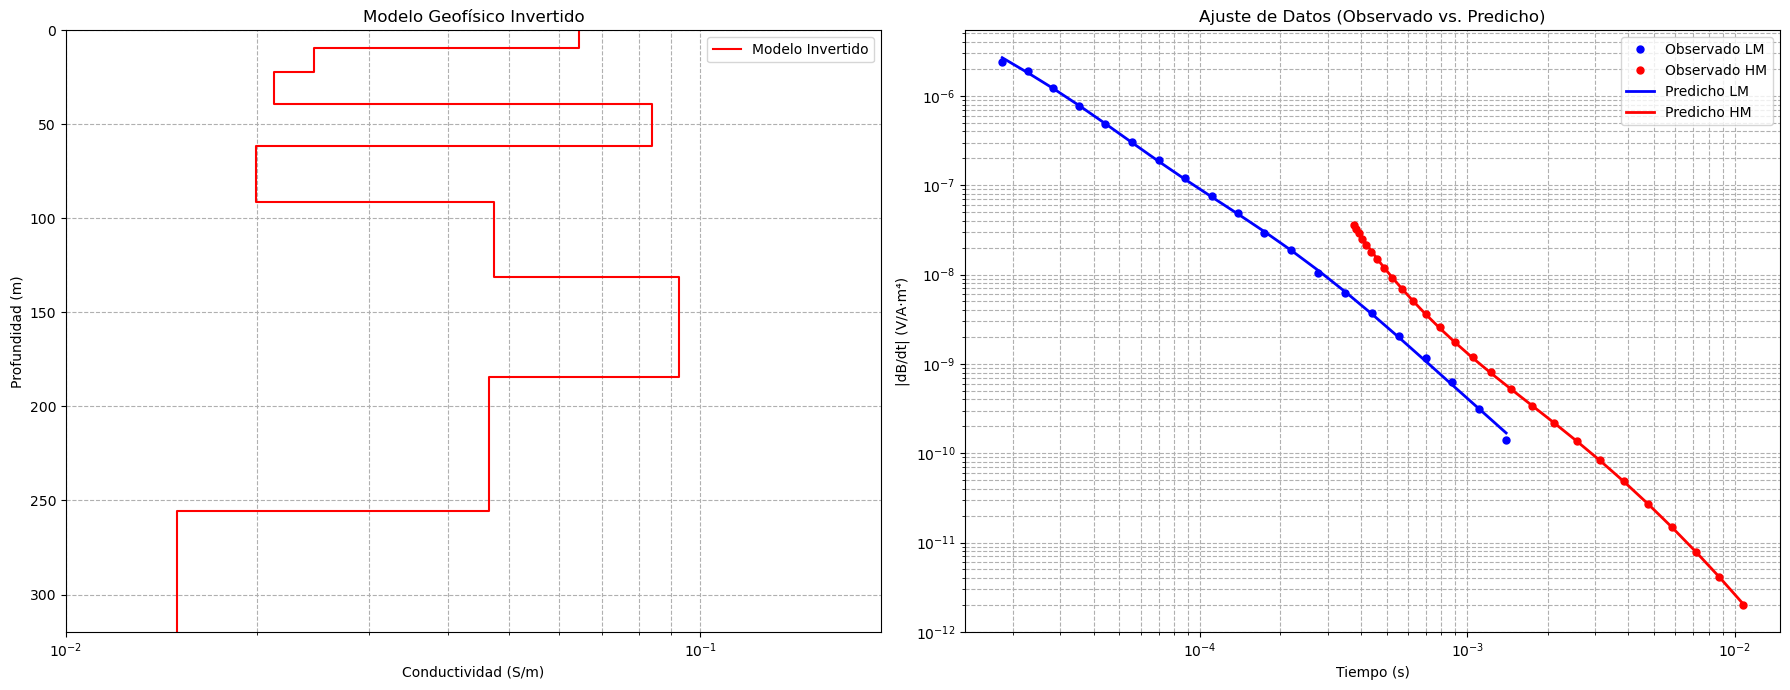

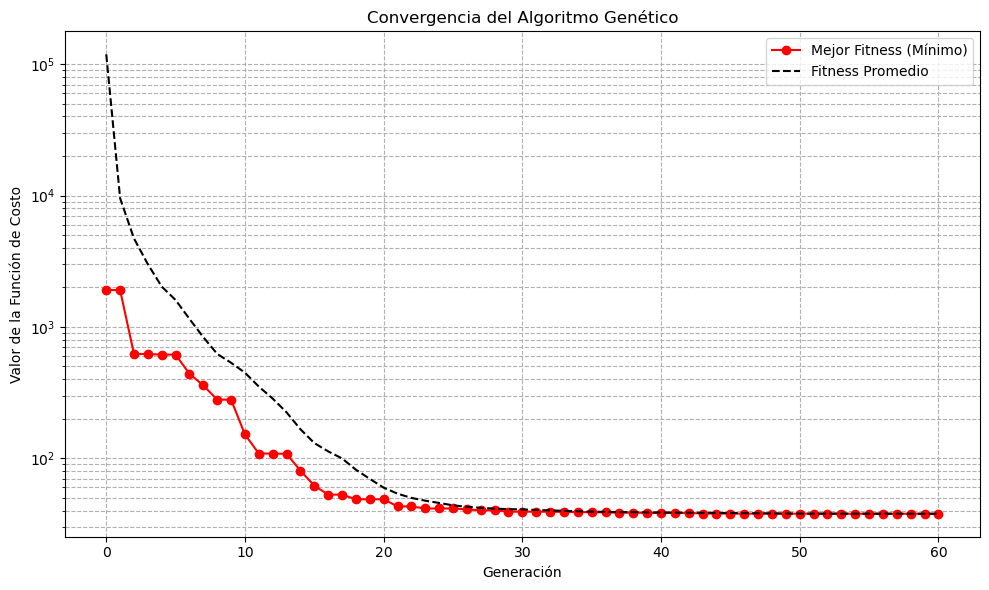

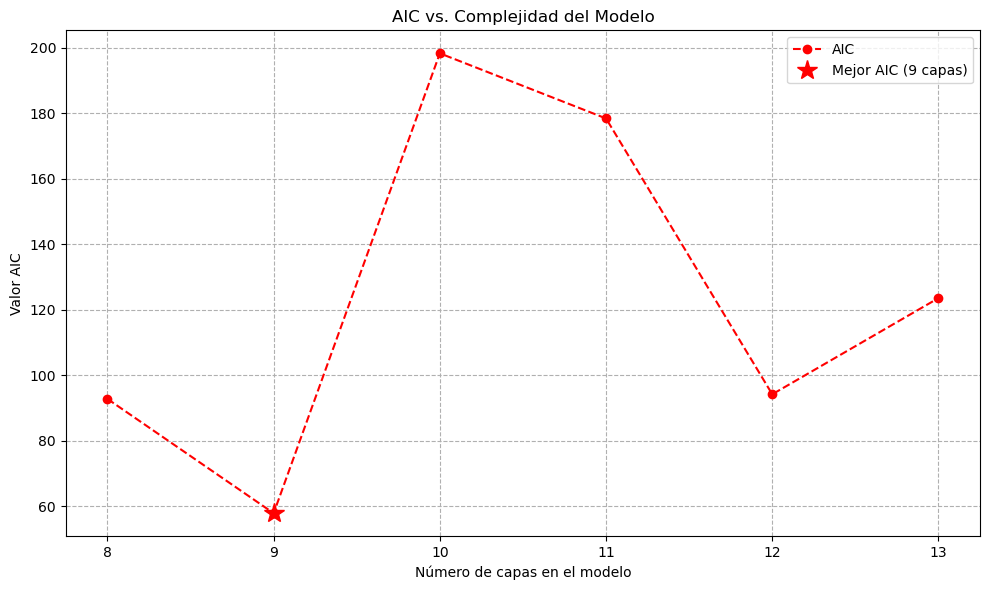

In [28]:
def calculate_log_layer_thicknesses(n_layers, total_thickness):
    if n_layers == 0: 
        inv_thicknesses = np.array([]) 
        n_celdas = 1 
    elif n_layers == 1: 
        inv_thicknesses = np.array([total_thickness])
        n_celdas = 2
    else: 
        start_log_thickness = 0
        end_log_thickness = 1
        relative_thicknesses = np.logspace(start_log_thickness, end_log_thickness, n_layers)

        inv_thicknesses = (relative_thicknesses / np.sum(relative_thicknesses)) * total_thickness
        n_celdas = n_layers + 1 

    return inv_thicknesses, n_celdas

def run_inversion_n_layers(n_layers, survey, dobs, uncertainties, total_thickness): 
    print(f"Iniciando inversión para {n_layers} capas ...")

    inv_thicknesses, n_celdas = calculate_log_layer_thicknesses(n_layers, total_thickness) 

    model_mapping = maps.ExpMap(nP=n_celdas) 
    simulation = tdem.Simulation1DLayered(
        survey=survey,
        thicknesses=inv_thicknesses,
        sigmaMap=model_mapping
    )

    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    log_min, log_max = np.log(1e-4), np.log(1) 
    toolbox.register("attr_float", np.random.uniform, log_min, log_max)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_celdas)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.3)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=log_min, up=log_max, eta=20.0, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    def evaluate(individual):
        model = np.array(individual)
        try:
            dpred = simulation.dpred(model) 
            misfit = np.sum(((dpred - dobs) / uncertainties)**2)
            roughness = np.sum(np.diff(model)**2) 
            alpha = 0.5 
            return misfit + alpha * roughness, 
        except Exception:
            return 1e12, 

    toolbox.register("evaluate", evaluate)

    # Ejecución del Algoritmo
    #Change the size of the population
    population = toolbox.population(n=100) 
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    hall_of_fame = tools.HallOfFame(1) 
        
    _, logbook = algorithms.eaMuPlusLambda(
        #Change the parameters as you want depending on your objective
        population, toolbox, mu=150, lambda_=150, 
        cxpb=0.7, mutpb=0.1, ngen=60, 
        stats=stats, halloffame=hall_of_fame, verbose=False
    )
    
    best_model = np.array(hall_of_fame[0])
    misfit_final = hall_of_fame[0].fitness.values[0]

    if hasattr(creator, "FitnessMin"): 
        del creator.FitnessMin
    if hasattr(creator, "Individual"):
        del creator.Individual

    return best_model, logbook, misfit_final, inv_thicknesses, model_mapping

def penalized_cost(misfit, n_params, n_data):
    return 2 * n_params + misfit 

def run_and_process_layers(n_layers, survey, dobs, uncertainties, total_thickness): 
    print(f"Procesando la inversion para {n_layers} capas...")
    best_model, logbook, misfit, thicknesses, mapping = run_inversion_n_layers(n_layers, survey, dobs, uncertainties, total_thickness) 
    
    n_params = len(best_model)
    cost = penalized_cost(misfit, n_params, len(dobs))
    
    print(f"Finalizada inversión para {n_layers} capas. Misfit: {misfit:.4e}, AIC: {cost:.4e}")
    return {
        "n_layers": n_layers,
        "model": best_model,
        "logbook": logbook,
        "misfit": misfit,
        "aic": cost,
        "thicknesses": thicknesses,
        "mapping": mapping
    }

def plot_results(best_model, thicknesses, mapping, survey, dobs, lm_times, hm_times, n_lm_gates_final):
    """Grafica el modelo invertido y el ajuste de datos."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    conductivities = np.exp(best_model)
    
    min_conductivity = np.min(conductivities)
    max_conductivity = np.max(conductivities)

    plot_1d_layer_model(thicknesses, conductivities, ax=ax1, color='r', linestyle='-', label='Modelo Invertido')
    ax1.set_xscale('log')
    ax1.set_xlabel('Conductividad (S/m)')
    ax1.set_ylabel('Profundidad (m)')
    ax1.grid(True, which='both', linestyle='--')
    ax1.legend()
    ax1.set_title('Modelo Geofísico Invertido')
    #Change your axis limits if needed
    ax1.set_ylim([320, 0])
    ax1.set_xlim(min_conductivity, max_conductivity)

    simulation = tdem.Simulation1DLayered(
        survey=survey,
        thicknesses=thicknesses,
        sigmaMap=mapping
    )
    dpred = simulation.dpred(best_model)


    dobs_lm = dobs[:n_lm_gates_final]
    dobs_hm = dobs[n_lm_gates_final:]
    dpred_lm = dpred[:n_lm_gates_final]
    dpred_hm = dpred[n_lm_gates_final:]

    ax2.loglog(lm_times, abs(dobs_lm), 'bo', label='Observado LM', markersize=5)
    ax2.loglog(hm_times, abs(dobs_hm), 'ro', label='Observado HM', markersize=5)
    ax2.loglog(lm_times, abs(dpred_lm), 'b-', label='Predicho LM', lw=2)
    ax2.loglog(hm_times, abs(dpred_hm), 'r-', label='Predicho HM', lw=2)
    
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('|dB/dt| (V/A·m⁴)')
    ax2.grid(True, which='both', linestyle='--')
    ax2.legend()
    ax2.set_title('Ajuste de Datos (Observado vs. Predicho)')

    plt.tight_layout()
    plt.show()

def plot_convergence(logbook):
    gen = logbook.select("gen")
    min_vals = logbook.select("min")
    avg_vals = logbook.select("avg")
    
    plt.figure(figsize=(10, 6))
    plt.plot(gen, min_vals, 'r-o', label='Mejor Fitness (Mínimo)')
    plt.plot(gen, avg_vals, 'k--', label='Fitness Promedio')
    plt.xlabel("Generación")
    plt.ylabel("Valor de la Función de Costo")
    plt.yscale("log") 
    plt.grid(True, which="both", linestyle='--')
    plt.title("Convergencia del Algoritmo Genético")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    
    # Enter the range you want to try the inversions on
    layer_range = range(8, 14) 
    # Enter your DOI 
    total_thickness_for_inversion = 350.0  
    num_cores = multiprocessing.cpu_count()
    print(f"Utilizando {num_cores} núcleos para la inversión en paralelo...")
    
    args_para_mapear = [
        (n, srv, dobs, uncertainties, total_thickness_for_inversion) for n in layer_range
    ]
    
    with multiprocessing.Pool(processes=num_cores) as pool:
        results = pool.starmap(run_and_process_layers, args_para_mapear)

    best_result = min(results, key=lambda r: r["aic"])

    print("\n--- Inversión Completada ---")
    print(f"El modelo óptimo tiene {best_result['n_layers']} capas (según AIC).")
    print(f"  - Conductividades (S/m): {np.exp(best_result['model'])}")
    print(f"  - Espesores (m): {best_result['thicknesses']}")
    print(f"  - Misfit final regularizado: {best_result['misfit']:.4f}")
    print(f"  - Valor AIC: {best_result['aic']:.4f}")


    plot_results(
        best_result["model"],
        best_result["thicknesses"],
        best_result["mapping"],
        srv, dobs, lm_times, hm_times, n_lm_gates_final
    )
    
    plot_convergence(best_result["logbook"])
    
    capas = [r["n_layers"] for r in results]
    aics = [r["aic"] for r in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(capas, aics, 'o--r', label='AIC')
    plt.plot(best_result["n_layers"], best_result["aic"], 'r*', markersize=15, label=f'Mejor AIC ({best_result["n_layers"]} capas)')
    
    plt.xlabel("Número de capas en el modelo")
    plt.ylabel("Valor AIC")
    plt.xticks(capas) 
    plt.grid(True, which="both", linestyle='--')
    plt.title("AIC vs. Complejidad del Modelo")
    plt.legend()
    plt.tight_layout()
    plt.show()


--- Detalles de la Inversión para 12 Capas ---
  - Conductividades (S/m): [0.03973255 0.07784224 0.02135852 0.01218759 0.03629181 0.09525303
 0.04935344 0.02103248 0.00885833 0.18701482 0.00437228 0.00174225
 0.00281428]
  - Espesores (m): [ 7.19394389  8.86903027 10.93415505 13.4801374  16.61894344 20.48861024
 25.25931633 31.14086577 38.39191483 47.33134702 58.35229685 71.93943891]
  - Misfit final regularizado: 68.1950
  - Valor AIC: 94.1950

--- Generando gráficos para la inversión de 12 capas ---


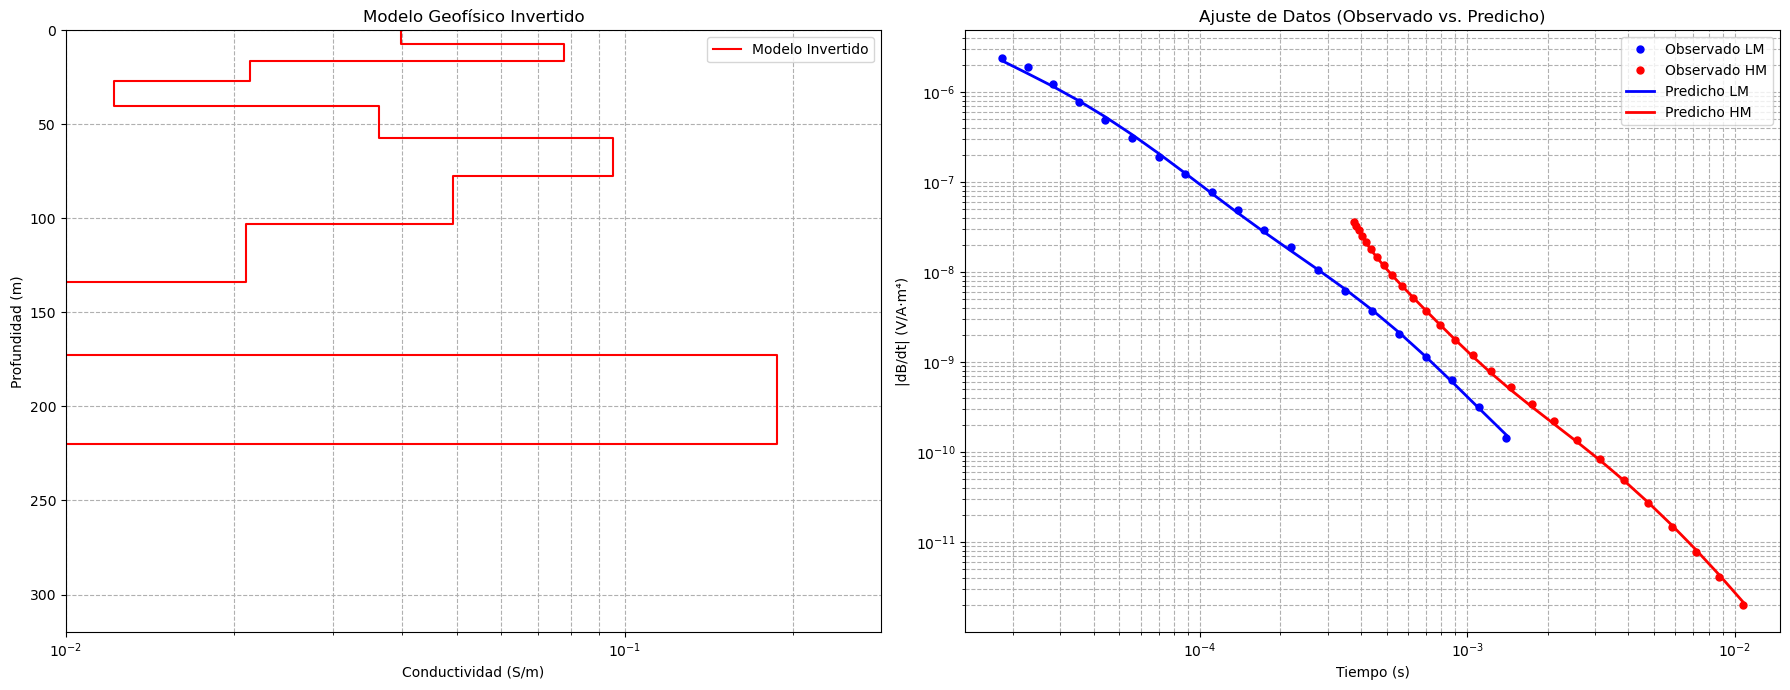

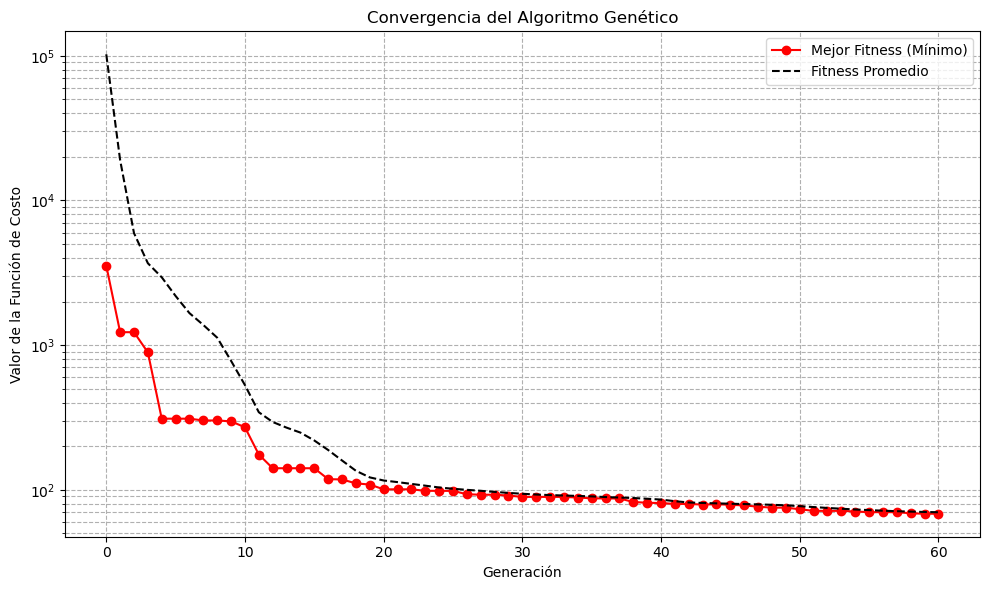

In [30]:
#Print other inversion if needed
selected_n_layers = 12

selected_result = next((r for r in results if r["n_layers"] == selected_n_layers), None)

if selected_result:
    print(f"\n--- Detalles de la Inversión para {selected_n_layers} Capas ---")
    print(f"  - Conductividades (S/m): {np.exp(selected_result['model'])}")
    print(f"  - Espesores (m): {selected_result['thicknesses']}")
    print(f"  - Misfit final regularizado: {selected_result['misfit']:.4f}")
    print(f"  - Valor AIC: {selected_result['aic']:.4f}")
    print(f"\n--- Generando gráficos para la inversión de {selected_n_layers} capas ---")
    plot_results(
        selected_result["model"],
        selected_result["thicknesses"],
        selected_result["mapping"],
        srv, dobs, lm_times, hm_times, n_lm_gates_final
    )
    plot_convergence(selected_result["logbook"])
else:
    print(f"\nNo se encontraron resultados para {selected_n_layers} capas en el rango probado.")